<a href="https://colab.research.google.com/github/taoerman/cs7643/blob/main/AutoEncoder_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load data from My Drive
train_data = np.load('/content/drive/My Drive/train_split.npy', allow_pickle=True).item()
val_data = np.load('/content/drive/My Drive/val_split.npy', allow_pickle=True).item()
test_data = np.load('/content/drive/My Drive/test-release.npy', allow_pickle=True).item()

In [5]:
# train data processing, generate 2 * 2 * 7 = 28 train features by frames
train_features = []
train_labels = []

for sequence in train_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    # Flatten features from (frames, 2 mice , 2 xy , 7 keypoints) into (frames, 28)
    features_flat = keypoints.reshape(num_frames, -1)

    train_features.append(features_flat)
    train_labels.append(annotations)

# concatenate all vedio (sequences)
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)


print(train_features.shape)
print(train_labels.shape)

(426635, 28)
(426635,)


In [6]:
# validation data processing
val_features = []
val_labels = []

for sequence in val_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    features_flat = keypoints.reshape(num_frames, -1)

    val_features.append(features_flat)
    val_labels.append(annotations)

val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


print(val_features.shape)
print(val_labels.shape)

(81103, 28)
(81103,)


An AutoEncoder to compress high-dimensional features (28D features) into a latent space (32D latent vector)

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z  # return the reconstructed input and the latent vector

A classifier that uses the latent feature to predict behavior classes

In [ ]:

class Classifier(nn.Module):
    def __init__(self, bottleneck_dim=32, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(bottleneck_dim, 64), #2-layer MLP : [32 -> 64 -> 4]
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, z):
        return self.fc(z)

In [28]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume these exist:
# train_features, train_labels, val_features, val_labels

# Move data to device
X = torch.tensor(train_features, dtype=torch.float32)
y = torch.tensor(train_labels, dtype=torch.long)
val_X = torch.tensor(val_features, dtype=torch.float32)
val_y = torch.tensor(val_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X, y), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=256)

# ------------------------
# 3. Models and Optimizer
# ------------------------

# Model Instantiation
input_dim = X.shape[1]
ae = AutoEncoder(input_dim=input_dim, bottleneck_dim=32).to(device)
clf = Classifier(bottleneck_dim=32, num_classes=4).to(device)


params = list(ae.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

recon_loss_fn = nn.MSELoss() #measures how close x_hat is to original x
class_loss_fn = nn.CrossEntropyLoss() #measures multi-class classification error
beta = 1.0

# ------------------------
# 4. Tracking Variables
# ------------------------

train_acc_list = []
val_acc_list = []
train_f1_list = []
val_f1_list = []

# ------------------------
# 5. Training Loop
# ------------------------

for epoch in range(30):
    ae.train()
    clf.train()
    total_recon_loss = 0
    total_class_loss = 0

    y_true_train = []
    y_pred_train = []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        x_hat, z = ae(batch_X)
        logits = clf(z)

        loss_recon = recon_loss_fn(x_hat, batch_X) #MSE between reconstructed and original input
        loss_class = class_loss_fn(logits, batch_y) #Cross-Entropy Loss between predicted logits and true class
        loss = loss_recon + beta * loss_class
        loss.backward()
        optimizer.step() #backward to update gradients and params

        total_recon_loss += loss_recon.item()
        total_class_loss += loss_class.item()

        # Track training predictions
        preds = torch.argmax(logits, dim=1)
        y_true_train.extend(batch_y.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    # Compute train accuracy/F1
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

    # Validation
    ae.eval()
    clf.eval()
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for val_batch_X, val_batch_y in val_loader:
            val_batch_X = val_batch_X.to(device)
            z_val = ae.encoder(val_batch_X)
            logits_val = clf(z_val)
            preds_val = torch.argmax(logits_val, dim=1)

            y_true_val.extend(val_batch_y.numpy())
            y_pred_val.extend(preds_val.cpu().numpy())

    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    print(f"Epoch {epoch+1} | Recon Loss: {total_recon_loss:.4f} | Class Loss: {total_class_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} "
          f"| Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

Epoch 1 | Recon Loss: 4635757.4809 | Class Loss: 1638.9510 | Train Acc: 0.7484 | Train F1: 0.4836 | Val Acc: 0.7675 | Val F1: 0.5375
Epoch 2 | Recon Loss: 143743.4114 | Class Loss: 1014.4023 | Train Acc: 0.8067 | Train F1: 0.5806 | Val Acc: 0.8512 | Val F1: 0.5936
Epoch 3 | Recon Loss: 101567.5717 | Class Loss: 896.5198 | Train Acc: 0.8227 | Train F1: 0.6033 | Val Acc: 0.8407 | Val F1: 0.6147
Epoch 4 | Recon Loss: 69380.7858 | Class Loss: 802.5570 | Train Acc: 0.8332 | Train F1: 0.6139 | Val Acc: 0.8720 | Val F1: 0.6209
Epoch 5 | Recon Loss: 53721.0617 | Class Loss: 752.4641 | Train Acc: 0.8419 | Train F1: 0.6213 | Val Acc: 0.8672 | Val F1: 0.6564
Epoch 6 | Recon Loss: 44561.5605 | Class Loss: 718.2771 | Train Acc: 0.8490 | Train F1: 0.6261 | Val Acc: 0.8878 | Val F1: 0.6474
Epoch 7 | Recon Loss: 37598.0025 | Class Loss: 686.7206 | Train Acc: 0.8550 | Train F1: 0.6269 | Val Acc: 0.8721 | Val F1: 0.6357
Epoch 8 | Recon Loss: 32145.5088 | Class Loss: 657.3024 | Train Acc: 0.8612 | Train 

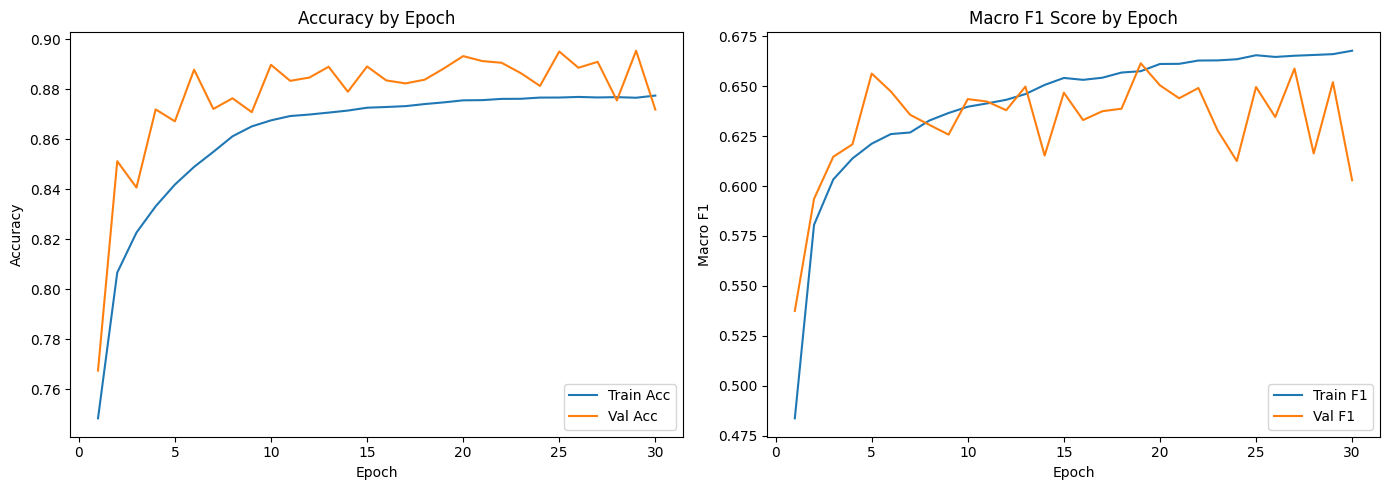

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list, label='Val Acc')
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1_list, label='Train F1')
plt.plot(epochs, val_f1_list, label='Val F1')
plt.title("Macro F1 Score by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.legend()

plt.tight_layout()
plt.show()